In [ ]:
import random
x = [1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5]

a = pd.DataFrame(np.asmatrix([x, [random.randint(0, 100) for z in range(len(x))]]).T, columns=['Label', 'Value'])
a

z = a[a['Label'] == 1]
def tr(t, offset=1):
    t['norm'] = (t['Value'] - t['Value'].mean())/t['Value'].std()
    t['id'] = range(len(t))
    return t[offset:]
tr(z)

a.groupby("Label").apply(tr)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/

In [41]:
df = pd.read_csv("confirmed_diff.csv")
df.dropna()
df = df[['region', 'Value', 'Province_State']]
# subset = ["South Carolina", "California", 
#           "North Carolina", "New York", 
#           "New Jersey", "Georgia", 
#           "Ohio", "Florida", 
#           "Massachusetts", "Washington"]
# df = df[df['Province_State'].isin(subset)]

In [42]:
df['Province_State'].unique()

array(['South Carolina', 'Louisiana', 'Virginia', 'Idaho', 'Iowa',
       'Kentucky', 'Missouri', 'Oklahoma', 'Colorado', 'Illinois',
       'Indiana', 'Mississippi', 'Nebraska', 'North Dakota', 'Ohio',
       'Pennsylvania', 'Washington', 'Wisconsin', 'Vermont', 'Minnesota',
       'Florida', 'North Carolina', 'California', 'New York', 'Wyoming',
       'Michigan', 'Alaska', 'Maryland', 'Kansas', 'Tennessee', 'Texas',
       'Maine', 'Arizona', 'Georgia', 'Arkansas', 'New Jersey',
       'South Dakota', 'Alabama', 'Oregon', 'West Virginia',
       'Massachusetts', 'Utah', 'Montana', 'New Hampshire', 'New Mexico',
       'Rhode Island', 'Nevada', 'District of Columbia', 'Connecticut',
       'Hawaii', 'Delaware', 'Diamond Princess', 'Grand Princess', 'Guam',
       'Puerto Rico', 'Virgin Islands', 'Northern Mariana Islands',
       'American Samoa'], dtype=object)

In [43]:
OFFSET = 5
regions = df['region'].unique()
region_dict = {regions[x]:x for x in range(len(regions))}
subset = ["South Carolina", "California", 
          "North Carolina", "New York", 
          "New Jersey", "Georgia", 
          "Ohio", "Florida", 
          "Massachusetts", "Washington"]
test_region = ['Illinois', 'Texas', 'Nevada']
# df['region_encode'] = df.apply(lambda x: region_dict[x['region']], axis=1)
traindf = df[df['Province_State'].isin(subset)]
testdf = df[df['Province_State'].isin(test_region)]

def organize_data(x, days_offset=5):
    x['id'] = range(len(x))
    x['norm-0'] = (x['Value'] - x['Value'].mean()) / x['Value'].std()
    for item in range(days_offset):
        x['norm-%s'%str(item+1)] = x.shift(periods=(1+item))['norm-0']
    out = x[days_offset:]
    return out
# tdf

In [44]:
tr_df = traindf.groupby('region').apply(organize_data)
tr_df['region_encode'] = tr_df.apply(lambda x: region_dict[x['region']], axis=1)
te_df = testdf.groupby("region").apply(organize_data)
te_df['region_encode'] = te_df.apply(lambda x: region_dict[x['region']], axis=1)

In [45]:
tr_df.index = tr_df.index.droplevel()
te_df.index = te_df.index.droplevel()

In [46]:
tr_df.pop("Value")
tr_df.pop("id")
tr_df.pop("region")
tr_df.pop("Province_State")
# --------
te_df.pop("Value")
te_df.pop("id")
te_df.pop("region")
te_df.pop("Province_State")

1025      Illinois
1026      Illinois
1027      Illinois
1028      Illinois
1029      Illinois
            ...   
331801       Texas
331802       Texas
331803       Texas
331804       Texas
331805       Texas
Name: Province_State, Length: 36763, dtype: object

In [47]:
train_labels = tr_df.pop('norm-0')
test_labels = te_df.pop("norm-0")

In [48]:
def build_model(train_dataset):
    model = keras.Sequential([
        layers.Dense(128, activation="relu", input_shape=[len(train_dataset.keys())]),
        layers.Dense(128, activation="relu"),
        layers.Dense(1)
    ])
    
    optimizer = tf.keras.optimizers.RMSprop(0.001)
    model.compile(loss="mse",
                  optimizer=optimizer,
                  metrics=['mae', 'mse'])
    return model
model = build_model(tr_df)

In [49]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 128)               896       
_________________________________________________________________
dense_7 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 129       
Total params: 17,537
Trainable params: 17,537
Non-trainable params: 0
_________________________________________________________________


In [50]:
ex_b = tr_df[tr_df['region_encode'] == region_dict['Wilson - North Carolina']][-10:]
ex_res = model.predict(ex_b)
ex_res

array([[307.42282],
       [307.378  ],
       [307.39893],
       [307.41318],
       [307.37933],
       [307.34616],
       [307.35046],
       [307.37192],
       [307.34998],
       [307.32935]], dtype=float32)

In [51]:
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: 
            print("")
        print(".", end="")

EPOCHS = 500
# Full Model Training
# history = model.fit(tr_df, train_labels, epochs=EPOCHS, validation_split=0.2, verbose=0, callbacks=[PrintDot()])
# hist = pd.DataFrame(history.history)
# hist['epoch'] = history.epoch
# hist.tail()
# plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)
# plotter.plot({'Basic': history}, metric = "mean_absolute_error")
# plt.ylim([0, 1])
# plt.ylabel('MAE [MPG]')


....................................

Text(0, 0.5, 'MAE [MPG]')

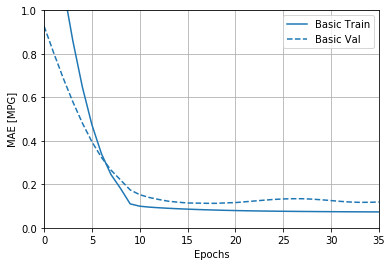

In [52]:
# Reduced model training, stops when the model continues to devastate
model = build_model(tr_df)
early_stop=keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
history=model.fit(tr_df, train_labels, epochs=EPOCHS,
                 validation_split=0.2, verbose=0, callbacks=[early_stop, PrintDot()])
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)
plotter.plot({'Basic': history}, metric = "mean_absolute_error")
plt.ylim([0, 1])
plt.ylabel('MAE [MPG]')

In [54]:
loss, mae, mse = model.evaluate(te_df, test_labels, verbose=2)
print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

36763/36763 - 0s - loss: 0.0857 - mean_absolute_error: 0.1646 - mean_squared_error: 0.0857
Testing set Mean Abs Error:  0.16 MPG


In [61]:
integrated_te_df = te_df.copy()
integrated_te_df['norm-0'] = test_labels
test_predictions = model.predict(te_df).flatten()
integrated_te_df['norm-0-pred'] = test_predictions

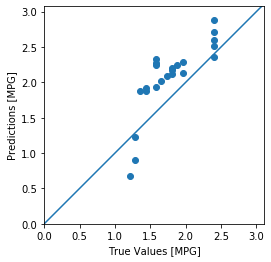

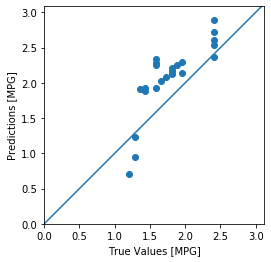

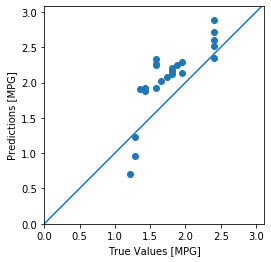

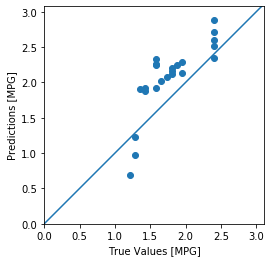

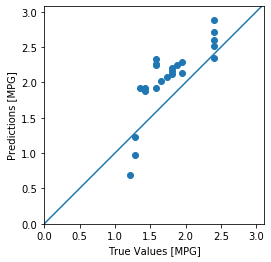

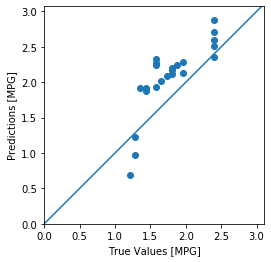

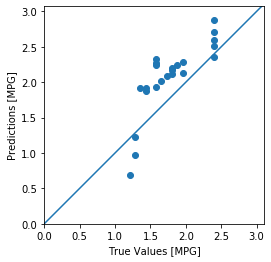

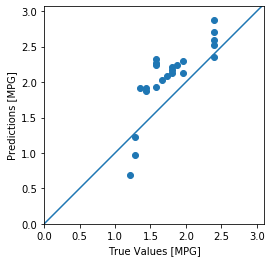

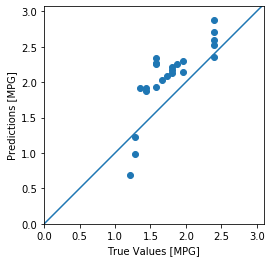

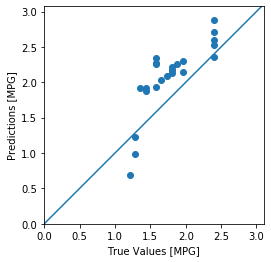

In [63]:
for x in integrated_te_df['region_encode'].unique()[:10]:
    subset = integrated_te_df[integrated_te_df['region_encode'] == x]
    plt.scatter(subset['norm-0'], subset['norm-0-pred'])
    plt.xlabel('True Values [MPG]')
    plt.ylabel('Predictions [MPG]')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim([0,plt.xlim()[1]])
    plt.ylim([0,plt.ylim()[1]])
    plt.plot([-100, 100], [-100, 100])
    plt.show()
    

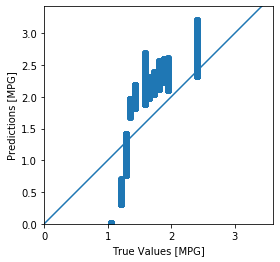

In [55]:
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
plt.plot([-100, 100], [-100, 100])

Text(0, 0.5, 'Count')

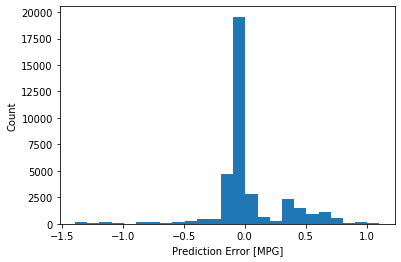

In [56]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel("Prediction Error [MPG]")
plt.ylabel("Count")

TypeError: unsupported operand type(s) for -: 'list' and 'list'